In [1]:
import os
import pathlib

p_project = str(pathlib.Path(os.getcwd()).parents[1])

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from datetime import timedelta

import numpy as np

In [4]:
adm=pd.read_csv(p_project + "/data/pic/ADMISSIONS.csv.gz", compression='gzip')
adm.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_DEPARTMENT,DISCHARGE_DEPARTMENT,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,ICD10_CODE_CN,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,1,26,100000,2098-11-09 18:30:55,2098-11-14 09:18:00,NaN,General ICU,General ICU,Self Pay,CHN,Not specified,Single,Han ethnic,2098-11-09 18:30:55,2098-11-14 09:18:00,肠粘膜炎,K52.901,0,0
1,2,28,100001,2104-09-03 10:36:47,2104-09-12 14:51:00,2104-09-12 14:51:00,General ICU,General ICU,Self Pay,CHN,Not specified,Single,Han ethnic,2104-09-03 10:36:47,2104-09-12 14:51:00,心肌炎,I51.403,1,0
2,3,29,100002,2062-11-29 20:52:52,2062-12-07 14:27:00,NaN,General ICU,General ICU,Self Pay,CHN,Not specified,Single,Han ethnic,2062-11-29 20:52:52,2062-12-07 14:27:00,溺水,T75.101,0,0
3,4,30,100003,2098-11-21 15:38:47,2098-11-26 01:33:00,2098-11-26 01:33:00,General ICU,General ICU,Discount,CHN,Not specified,Single,Han ethnic,2098-11-21 15:38:47,2098-11-26 01:33:00,NaN,NaN,1,0
4,5,31,100004,2071-11-13 19:43:13,2071-11-15 13:40:00,2071-11-15 13:40:00,General ICU,General ICU,Self Pay,CHN,Not specified,Single,Han ethnic,2071-11-13 19:43:13,2071-11-15 13:40:00,腹泻病,K52.904,1,0


In [5]:
#Load the patients data base and add the Date of birth to the admission dataset.
patients_df=pd.read_csv(p_project + "/data/pic/PATIENTS.csv.gz", compression="gzip")
patients_df["DOBTIME"]=pd.to_datetime(patients_df["DOB"], format='%Y-%m-%d')
adm_dob=pd.merge(patients_df[["SUBJECT_ID","DOBTIME"]],adm,on="SUBJECT_ID")

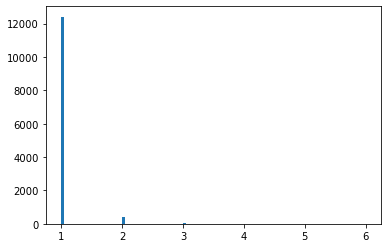

Number of patients with specific number of admissions : 
 1    12413
2      389
3       62
4       14
5        2
6        1
Name: HADM_ID, dtype: int64


In [6]:
#Number of admissions by patient
df=adm.groupby("SUBJECT_ID")["HADM_ID"].nunique()
plt.hist(df,bins=100)
plt.show()
print("Number of patients with specific number of admissions : \n",df.value_counts())

As the majortity of patients only present a single admission, we filter out all the patients with more than 1 admission

In [7]:
subj_ids=list(df[df==1].index) #index of patients with only one visit.
adm_1=adm_dob.loc[adm_dob["SUBJECT_ID"].isin(subj_ids)] #filter out the patients with more than one visit
print("Number of patients remaining in the dataframe: ")
print(len(adm_1.index))

Number of patients remaining in the dataframe: 
12413


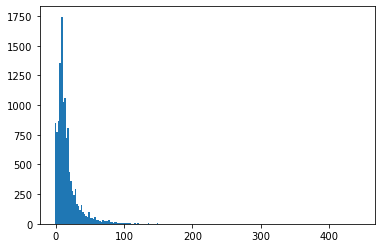

Number of patients with specific duration of admissions in days : 
 7      725
8      650
6      634
9      575
13     569
      ... 
104      1
129      1
444      1
221      1
106      1
Name: ELAPSED_DAYS, Length: 141, dtype: int64


In [8]:
#We now add a new column with the duration of each stay.
adm_1=adm_1.copy()
adm_1['ADMITTIME']=pd.to_datetime(adm_1["ADMITTIME"], format='%Y-%m-%d %H:%M:%S')
adm_1['DISCHTIME']=pd.to_datetime(adm_1["DISCHTIME"], format='%Y-%m-%d %H:%M:%S')

adm_1["ELAPSED_TIME"]=adm_1["DISCHTIME"]-adm_1["ADMITTIME"]
adm_1["ELAPSED_DAYS"]=adm_1["ELAPSED_TIME"].dt.days #Elapsed time in days in ICU
plt.hist(adm_1["ELAPSED_DAYS"],bins=200)
plt.show()
print("Number of patients with specific duration of admissions in days : \n",adm_1["ELAPSED_DAYS"].value_counts())

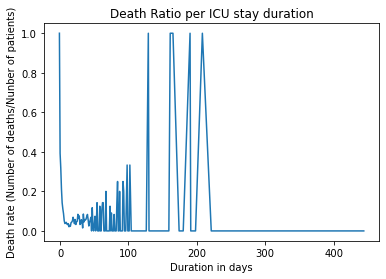

In [9]:
#Let's now report the death rate in function of the duration stay in ICU.
adm_1["DEATHTAG"]=0
adm_1.loc[adm_1.DEATHTIME.notnull(),"DEATHTAG"]=1

df_deaths_per_duration=adm_1.groupby("ELAPSED_DAYS")["DEATHTAG"].sum()
df_patients_per_duration=adm_1.groupby("ELAPSED_DAYS")["SUBJECT_ID"].nunique()
df_death_ratio_per_duration=df_deaths_per_duration/df_patients_per_duration
plt.plot(df_death_ratio_per_duration)
plt.title("Death Ratio per ICU stay duration")
plt.xlabel("Duration in days")
plt.ylabel("Death rate (Number of deaths/Nunber of patients)")
plt.show()

Given the results above, we select patients with a least 48 hours in the ICU and with less than 30 days stay.

In [16]:
adm_2=adm_1.loc[(adm_1["ELAPSED_DAYS"]<30) & (adm_1["ELAPSED_DAYS"]>2)]
print("Number of patients remaining in the dataframe: ")
print(len(adm_2.index))

Number of patients remaining in the dataframe: 
9520


We remove the admissions with no chart events data.

In [18]:
adm_2_chart=adm_2.loc[adm_2["HAS_CHARTEVENTS_DATA"]==1].copy()
print("Number of patients remaining in the dataframe: ")
print(len(adm_2_chart.index))

Number of patients remaining in the dataframe: 
7712


In [21]:
#We now investigate the admission_type
df_type=adm_2_chart.groupby("ADMISSION_DEPARTMENT")["SUBJECT_ID"].count()
df_type

ADMISSION_DEPARTMENT
Burn/Neurosurgery department                      1108
CICU                                                54
Cardiac surgery department                        1927
Cardiovascular department                           86
Endocrinology department                            33
Gastroenterology department                         47
General ICU                                         44
General surgery/Endoscopy department               289
General surgery/Neonatology surgery department     753
Infectious diseases department                      41
NICU                                              1141
Neonatology department(1)                           75
Neonatology department(2)                           75
Neurology department                                53
Ophthalmology department/ENT                        61
Orthopedics/Traumatology department                 15
PICU                                               924
Respiratory medicine department(1)          

We remove the newborns as they are specific

In [ ]:
# adm_3=adm_2_chart.loc[adm_2_chart["ADMISSION_TYPE"]!="NEWBORN"]
# print("Number of patients remaining in the dataframe: ")
# print(adm_3["SUBJECT_ID"].nunique())

In [23]:
adm_2_chart.to_csv(p_project + "/temp/pic/processed/admissions_processed.csv")